# LPL Data Cleaner

## 1) EDA

# Packages + Data Load

In [89]:
%pip install pandas openpyxl matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import os

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [90]:
file_path = r"C:\Users\MarkBogorad\OneDrive - Rockefeller Capital Management\MarkB\RCM\data\Stifel_Master_ContactList_6.10.25.xlsx"
df = pd.read_excel(file_path)

# Display the first few rows
df.head()


,First Name,Last Name,Full Name,Firm,Contact Owner,Tier (Muni Use),Address1,Address2,Email,Team,City,State2,Zip,Manager Phone,Phone,FA Name,Job Title,Test Combos
0,Angela,Johnson,Angela Johnson,Stifel,NaN,NaN,18000 West Sarah Lane,NaN,angela.johnson@stifel.com,NaN,Brookfield,WI,53045,NaN,NaN,NaN,Financial Advisor,2.0
1,Carl,Petersen,Carl Petersen,Stifel,NaN,NaN,50 W. Liberty,NaN,carl.petersen@stifel.com,NaN,Reno,NV,89501,NaN,NaN,NaN,Vice President/Investments,2.0
2,Barry,Gangwer,Barry Gangwer,Stifel,NaN,NaN,6301 Waterford Boulevard,NaN,barry.gangwer@stifel.com,NaN,Oklahoma City,OK,73118,NaN,NaN,NaN,Sr. VP/Investments,2.0
3,David,Parker,David Parker,Stifel,NaN,NaN,100 North Tampa Street,NaN,david.parker@stifel.com,NaN,Tampa,FL,33602,NaN,NaN,NaN,Vice President/Investments,2.0
4,Dan,Spring,Dan Spring,Stifel,NaN,NaN,38 East Main Street,NaN,dan.spring@stifel.com,NaN,Mystic,CT,6355,NaN,NaN,NaN,Branch Manager,2.0


# Dupe Check

In [91]:
# Count duplicates in the 'Email' column
num_duplicates = df.duplicated(subset='Email').sum()

# Drop duplicate rows based on the 'Email' column, keeping only the first occurrence
df_cleaned = df.drop_duplicates(subset='Email', keep='first')


print(f"{num_duplicates} duplicate email(s) removed")



2609 duplicate email(s) removed


# Adding in Empty First and Last Names

In [92]:
# Fill missing first/last names from Full Name
for index, row in df.iterrows():
    if pd.notna(row['Full Name']) and (pd.isna(row.get('First Name')) or pd.isna(row.get('Last Name'))):
        parts = row['Full Name'].strip().split()
        if len(parts) >= 2:
            df.at[index, 'First Name'] = parts[0]
            df.at[index, 'Last Name'] = parts[-1]


# Contacts vs Bounce Cross Reference

- 1 = unverified (worth testing)
- 2 = bounced (need to test)
- 0 = confirmed right conact

# Bounced Emails Alternatives

In [93]:

# Step 1: Filter rows with Test Combos 1 or 2
test_df = df[df['Test Combos'].isin([1, 2])].copy()

# Step 2: Generate email variants from names
def generate_email_variants(first_name, last_name, domain="@stifel.com"):
    variants = set()
    first = first_name.lower()
    last = last_name.lower()

    variants.update([
        f"{first}.{last}",
        f"{last}.{first}",
        f"{first[0]}{last}",
        f"{last}{first[0]}"
    ])

    return [v + domain for v in variants]

# Step 3: Create new rows with generated emails
new_rows = []

for _, row in test_df.iterrows():
    full_name = row['Full Name']
    if pd.isna(full_name):
        continue

    parts = full_name.strip().split()
    if len(parts) < 2:
        continue  # skip if we can't split into first and last

    first, last = parts[0], parts[-1]
    email_variants = generate_email_variants(first, last)

    for email in email_variants:
        new_row = row.copy()
        new_row['Email'] = email
        new_row['Test Combos'] = 3
        new_rows.append(new_row)

# Step 4: Append new rows to original DataFrame
variant_df = pd.DataFrame(new_rows)
final_df = pd.concat([df, variant_df], ignore_index=True)

# Step 5: Save to Excel in the RCM/data folder
output_path = os.path.join(data_dir, 'final_email_list.xlsx')
final_df.to_excel(output_path, index=False)

print(f"Email variants saved to '{output_path}'.")



Email variants saved to 'c:\Users\MarkBogorad\OneDrive - Rockefeller Capital Management\MarkB\RCM\data\final_email_list.xlsx'.


# Bounced Emails Cross Check
- Scan bounced emails, use most common pattern from Stifel contacts to create variants of the bounced emails that should work

📁 Contents of RCM/data: ['bounce_list.xlsx', 'final_email_list.xlsx', 'remixed_bounced_emails.xlsx', 'Stifel_Master_ContactList_6.10.25.xlsx', 'Stifel_variations_list.xlsx']
✅ All required files found. Proceeding with processing...
📧 Found 1168 bounced emails.
✅ Found 281 correct emails for pattern analysis.
📊 Email pattern frequencies:
 Pattern
flast         166
first.last    115
Name: count, dtype: int64


C:\Users\MarkBogorad\AppData\Local\Temp\ipykernel_8308\950540188.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_emails_df.loc[:, 'Pattern'] = correct_emails_df['Email'].apply(extract_pattern)


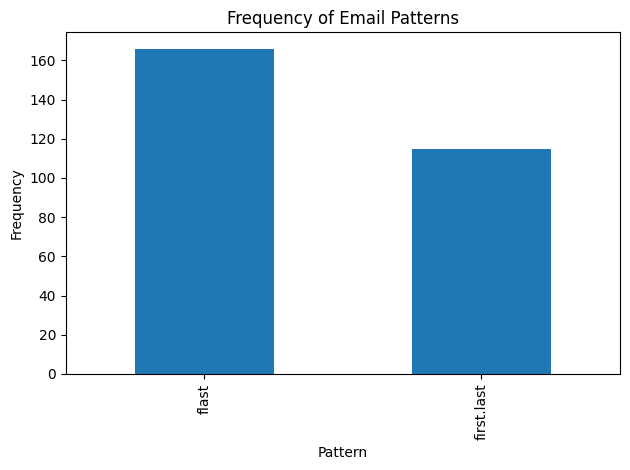

🔍 Most common pattern: flast
📬 Generated 1168 new email variants.
✅ Remixed bounced emails saved to 'c:\Users\MarkBogorad\OneDrive - Rockefeller Capital Management\MarkB\RCM\data\remixed_bounced_emails.xlsx'.


In [98]:

# Step out of smaller_projects into RCM
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Now access the existing data folder inside RCM
data_dir = os.path.join(project_root, 'data')

# Debug: Show contents of the data directory
print("📁 Contents of RCM/data:", os.listdir(data_dir))


# Define file paths
bounce_list_path = os.path.join(data_dir, 'bounce_list.xlsx')
stifel_list_path = os.path.join(data_dir, 'Stifel_variations_list.xlsx')

# Check if required files exist
if not os.path.exists(bounce_list_path):
    raise FileNotFoundError(f"Missing file: {bounce_list_path}")
if not os.path.exists(stifel_list_path):
    raise FileNotFoundError(f"Missing file: {stifel_list_path}")

print("✅ All required files found. Proceeding with processing...")

# Load the Excel files
bounce_list = pd.read_excel(bounce_list_path, engine='openpyxl')
stifel_list = pd.read_excel(stifel_list_path, engine='openpyxl')

# Extract bounced emails
bounced_emails = bounce_list[bounce_list['EmailBouncedReason'].notnull()]['Email'].tolist()
print(f"📧 Found {len(bounced_emails)} bounced emails.")

# Filter correct emails
correct_emails_df = stifel_list[stifel_list['Test Combos'] == 0]
print(f"✅ Found {len(correct_emails_df)} correct emails for pattern analysis.")

# Analyze email patterns
def extract_pattern(email):
    local_part = email.split('@')[0]
    if '.' in local_part:
        return 'first.last'
    elif len(local_part) > 1 and local_part[1:].isalpha():
        return 'flast'
    elif len(local_part) > 1 and local_part[:-1].isalpha():
        return 'lastf'
    else:
        return 'other'

correct_emails_df.loc[:, 'Pattern'] = correct_emails_df['Email'].apply(extract_pattern)

# Plot pattern frequency
pattern_counts = correct_emails_df['Pattern'].value_counts()
print("📊 Email pattern frequencies:\n", pattern_counts)

pattern_counts.plot(kind='bar')
plt.title('Frequency of Email Patterns')
plt.xlabel('Pattern')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Generate new email variants
most_common_pattern = pattern_counts.idxmax()
print(f"🔍 Most common pattern: {most_common_pattern}")

def generate_email_variant(full_name, pattern, domain="@stifel.com"):
    parts = full_name.strip().split()
    if len(parts) < 2:
        return None
    first, last = parts[0].lower(), parts[-1].lower()
    if pattern == 'first.last':
        return f"{first}.{last}{domain}"
    elif pattern == 'flast':
        return f"{first[0]}{last}{domain}"
    elif pattern == 'lastf':
        return f"{last}{first[0]}{domain}"
    else:
        return None

new_rows = []
for email in bounced_emails:
    row = bounce_list[bounce_list['Email'] == email]
    if not row.empty:
        first_name = row['FirstName'].values[0]
        last_name = row['LastName'].values[0]
        full_name = f"{first_name} {last_name}"
        new_email = generate_email_variant(full_name, most_common_pattern)
        if new_email:
            new_rows.append({
                'Full Name': full_name,
                'Email': new_email,
                'Test Combos': 3,
                'Source Bounced': email
            })

print(f"📬 Generated {len(new_rows)} new email variants.")

# Save to Excel
output_path = os.path.join(data_dir, 'remixed_bounced_emails.xlsx')
pd.DataFrame(new_rows).to_excel(output_path, index=False)

print(f"✅ Remixed bounced emails saved to '{output_path}'.")



# Cross Check Main DB with RIA DB
- Stifel contact list 6.11 vs RIA DB pull 6.12

In [115]:

# Step out of smaller_projects into RCM
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_dir = os.path.join(project_root, 'data')

# Define paths to both Excel files
stifel_path = os.path.join(data_dir, 'Stifel_Contact_Extract_6.11.25.xlsx')
ria_path = os.path.join(data_dir, 'RIA_Stifel.xlsx')

# Load the correct sheets
stifel_df = pd.read_excel(stifel_path, sheet_name='Stifel Contacts', engine='openpyxl')
ria_df = pd.read_excel(ria_path, sheet_name='Stifel Emails', engine='openpyxl')

# Normalize email columns (strip whitespace, lowercase)
stifel_emails = stifel_df['Email'].str.strip().str.lower()
ria_emails = ria_df['Email'].str.strip().str.lower()

# Find emails in RIA DB that are NOT in the Stifel list
new_emails_mask = ~ria_emails.isin(stifel_emails)
new_contacts_df = ria_df[new_emails_mask]

print(f"🆕 Found {len(new_contacts_df)} new contacts not in the Stifel list.")

# Save the new contacts to a new Excel file
output_path = os.path.join(data_dir, 'RIA_new_contacts_only.xlsx')
new_contacts_df.to_excel(output_path, index=False)

print(f"✅ New contacts saved to '{output_path}'.")



🆕 Found 619 new contacts not in the Stifel list.
✅ New contacts saved to 'c:\Users\MarkBogorad\OneDrive - Rockefeller Capital Management\MarkB\RCM\data\RIA_new_contacts_only.xlsx'.
